In [1]:
import cv2
import json
import keras
import numpy as np
from tqdm import tqdm
from pathlib import Path

from src.models.unet import IMAGE_SIZE, CLASSES, CHANNELS
from src.core.constants import KEYPOINTS
from src.core.utils import rescale_img, rescale_keypoints

class SegmentationDatasetGenerator(keras.utils.Sequence):

    def __init__(self, indices, idx2filename, idx2keypoints, batch_size, shuffle):

        self.indices = indices
        self.idx2filename = idx2filename
        self.idx2keypoints = idx2keypoints

        self.batch_size = batch_size
        self.shuffle = shuffle

        self.on_epoch_end()

    def on_epoch_end(self):
        if self.shuffle is True:
            np.random.shuffle(self.indices)

    def __len__(self):
        """Number of batches per epoch"""
        return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        """Get batch by index"""
        indices = self.indices[index * self.batch_size: (index + 1) * self.batch_size]
        batch_x, batch_y = self._get_data(indices)
        return batch_x, batch_y

    def _get_data(self, indices):
        x, y = [], []
        for index in indices:
            img = self._load_image(self.idx2filename[index])
            keypoints = self.idx2keypoints[index]
            heatmap = self._get_heatmap(img, keypoints, sigma=13)
            x.append(img)
            y.append(heatmap)

        return np.array(x, dtype=np.float32), np.array(y, dtype=np.float32)

    def _load_image(self, file_path):
        img = cv2.imread(file_path)
        img = rescale_img(img, resolution=IMAGE_SIZE)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = np.float32(img) / 255
        return img

    def _get_heatmap(self, img, keypoints, sigma):
        img_h, img_w, _  = img.shape

        mask = np.zeros((img_h, img_w, CLASSES))
        xv = np.arange(img_w)
        yv = np.arange(img_h)
        xx, yy = np.meshgrid(xv, yv)

        for kp_name, kp_info in KEYPOINTS.items():
            kp_id = kp_info['id']
            if kp_name in keypoints:
                x, y = keypoints[kp_name]
                gaussian = (yy - y) ** 2
                gaussian += (xx - x) ** 2
                gaussian *= -1
                gaussian = gaussian / (2 * sigma ** 2)
                gaussian = np.exp(gaussian)
                mask[:, :, kp_id] = gaussian

        heatmap = np.reshape(mask, newshape=(img_h * img_w * CLASSES, 1))
        return heatmap


def get_data(dataset_path, batch_size):

    dataset_path = Path(dataset_path)

    raw_data_path = dataset_path / 'raw'
    test_txt_path = dataset_path / 'test.txt'

    test_images = []

    with open(str(test_txt_path), 'r') as file:
        for line in file:
            test_images.append(line.strip())

    train_entries, test_entries = [], []

    for img_path in tqdm(raw_data_path.glob('*/*.png')):
        anno_path = img_path.parent / 'annotation' / f'{img_path.stem}.json'

        if not anno_path.exists():
            continue

        img = cv2.imread(str(img_path))
        img_h, img_w, _ = img.shape

        with open(str(anno_path), 'r') as file:
            keypoints = json.load(file)

        keypoints = rescale_keypoints(keypoints, src_resolution=(img_w, img_h), des_resolution=IMAGE_SIZE)

        if str(img_path.name) in test_images:
            test_entries.append((str(img_path), keypoints))
        else:
            train_entries.append((str(img_path), keypoints))

    indices = []
    idx2filepath = {}
    idx2keypoints = {}

    for idx in range(len(train_entries)):
        img_path, keypoints = train_entries[idx]
        indices.append(idx)
        idx2filepath[idx] = img_path
        idx2keypoints[idx] = keypoints

    np.random.shuffle(indices)

    split_point = int(0.9 * len(train_entries))

    train_indices = indices[:split_point]
    valid_indices = indices[split_point:]

    train_gen = SegmentationDatasetGenerator(
        train_indices,
        idx2filepath,
        idx2keypoints,
        batch_size=batch_size,
        shuffle=True
    )

    valid_gen = SegmentationDatasetGenerator(
        valid_indices,
        idx2filepath,
        idx2keypoints,
        batch_size=batch_size,
        shuffle=True
    )

    return train_gen, valid_gen

Using TensorFlow backend.
/home/andrii/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/andrii/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/andrii/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/andrii/miniconda3/lib/python3.7/site-packages/t

In [2]:
train_gen, valid_gen = get_data('/home/andrii/Data/thesis', 1)

5088it [01:58, 42.90it/s]


In [11]:
imgs, masks = train_gen[0]

In [15]:
img = imgs[0]
mask = masks[0]
mask = mask.reshape(IMAGE_SIZE[1], IMAGE_SIZE[0], CLASSES)
mask = np.sum(mask, axis=-1)

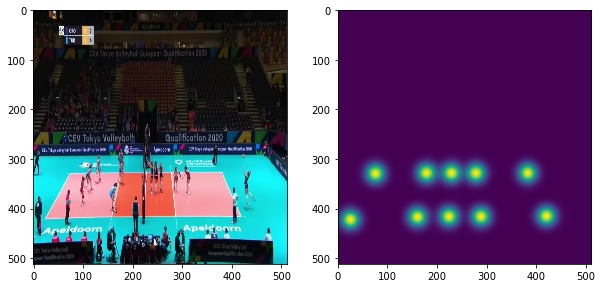

In [27]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 20))

fig.add_subplot(1, 2, 1)
plt.imshow(img)
fig.add_subplot(1, 2, 2)
plt.imshow(mask)
plt.show()

In [53]:
class MaskGenerator(keras.utils.Sequence):
    
    def __init__(self,
                 indices, 
                 idx2file, 
                 idx2keypoints, 
                 batch_size,
                 shuffle
        ):
        self.indices = indices
        self.idx2file = idx2file
        self.idx2keypoints = idx2keypoints

        self.batch_size = batch_size
        
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def on_epoch_end(self):
        if self.shuffle is True:
            np.random.shuffle(self.indices)
            
    def __len__(self):
        return int(np.round(len(self.indices) / self.batch_size))
    
    def _load_image(self, file_path):
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = np.float32(img) / 255
        return img
    
    def _keypoints2heatmap(self, img, keypoints, sigma=13):
        
        height, width, _ = img.shape
        
        mask = np.zeros((height, width, CLASSES))
        
        xv = np.arange(width)
        yv = np.arange(height)
        xx, yy = np.meshgrid(xv, yv)
        
        for name, info in KEYPOINTS.items():
            keypoint_id = info['id']
            
            if name in keypoints:
                
                x, y = keypoints[name]
                
                gaussian = (yy - y) ** 2
                gaussian += (xx - x) ** 2
                gaussian *= -1
                gaussian = gaussian / (2 * sigma ** 2)
                gaussian = np.exp(gaussian)
                
                mask[:, :, keypoint_id] = gaussian
                
        img_hm = np.reshape(mask, newshape=(height *  width * CLASSES, 1))
        return img_hm
    
    
    def _data_generation(self, indices):
        
        x = []
        y = []
        
        for idx in indices:
            img = self._load_image(self.idx2file[idx])
            keypoints = self.idx2keypoints[idx]
            img_hm = self._keypoints2heatmap(img, keypoints)
            x.append(img)
            y.append(img_hm)
            
        return np.array(x, dtype=np.float32), np.array(y, dtype=np.float32)
    
    def __getitem__(self, idx):
        
        start = idx * self.batch_size
        
        if idx + 1 * self.batch_size > len(self.indices):
            end = len(self.indices)
        else:
            end = idx + 1 * self.batch_size
            
        indices = self.indices[start:end]
        
        batch_x, batch_y = self._data_generation(indices)
        return batch_x, batch_y

In [6]:
def show_masks(img, gt_mask):
    
    fig = plt.figure()

    gt_mask = np.reshape(gt_mask, newshape=(IMAGE_SIZE[1], IMAGE_SIZE[0], CLASSES))
    gt_mask = np.sum(gt_mask, axis=-1)
    
    fig.add_subplot(2, 1, 1)
    plt.imshow(img)
    fig.add_subplot(2, 1, 2)
    plt.imshow(gt_mask)

    plt.show()

In [7]:
DATASET_PATH = Path('/home/andrii/Data/thesis')

raw_data_path = DATASET_PATH / 'raw'
segment_data_path = DATASET_PATH / 'segmentation'

segment_img_path = segment_data_path / 'img'

segment_img_path.mkdir(exist_ok=True, parents=True)

test_images = []

test_txt = DATASET_PATH / 'test.txt'

with open(str(test_txt), 'r') as file:
    for line in file:
        test_images.append(line.strip())

In [8]:
img_list = [x for x in raw_data_path.glob('*/*.png')]

train_entries = []
test_entries = []

for i, img_path in enumerate(img_list):
    
    if i % 100 == 0:
        print(f'Processed: {i}/{len(img_list)}')
    
    anno_path = img_path.parent / 'annotation' / f'{img_path.stem}.json'

    if anno_path.exists():
        img = cv2.imread(str(img_path))
        
        h, w, _ = img.shape

        with open(str(anno_path), 'r') as file:
            anno = json.load(file)

        anno = rescale_anno(anno, src_resolution=(w, h), des_resolution=IMAGE_SIZE)
        img = rescale_img(img, resolution=IMAGE_SIZE)
        
        target_img_path = segment_img_path / img_path.name
        
        cv2.imwrite(str(target_img_path), img)
        
        if str(img_path.name) not in test_images:
            train_entries.append((str(target_img_path), anno))
        else:
            test_entries.append((str(target_img_path), anno))

Processed: 0/5088
Processed: 100/5088
Processed: 200/5088
Processed: 300/5088
Processed: 400/5088
Processed: 500/5088
Processed: 600/5088
Processed: 700/5088
Processed: 800/5088
Processed: 900/5088
Processed: 1000/5088
Processed: 1100/5088
Processed: 1200/5088
Processed: 1300/5088
Processed: 1400/5088
Processed: 1500/5088
Processed: 1600/5088
Processed: 1700/5088
Processed: 1800/5088
Processed: 1900/5088
Processed: 2000/5088
Processed: 2100/5088
Processed: 2200/5088
Processed: 2300/5088
Processed: 2400/5088
Processed: 2500/5088
Processed: 2600/5088
Processed: 2700/5088
Processed: 2800/5088
Processed: 2900/5088
Processed: 3000/5088
Processed: 3100/5088
Processed: 3200/5088
Processed: 3300/5088
Processed: 3400/5088
Processed: 3500/5088
Processed: 3600/5088
Processed: 3700/5088
Processed: 3800/5088
Processed: 3900/5088
Processed: 4000/5088
Processed: 4100/5088
Processed: 4200/5088
Processed: 4300/5088
Processed: 4400/5088
Processed: 4500/5088
Processed: 4600/5088
Processed: 4700/5088
Proc

In [9]:
indices = []
idx2file = {}
idx2keypoints = {}


for idx in range(len(train_entries)):
    file, keypoints = train_entries[idx]
    indices.append(idx)
    idx2file[idx] = file
    idx2keypoints[idx] = keypoints

In [15]:
np.random.shuffle(indices)

cutoff_idx = int(0.9 * len(indices))

train_indices = indices[:cutoff_idx]
valid_indices = indices[cutoff_idx:]

train_gen = MaskGenerator(train_indices, idx2file, idx2keypoints, batch_size=1, shuffle=True)
valid_gen = MaskGenerator(valid_indices, idx2file, idx2keypoints, batch_size=1, shuffle=True)

In [16]:
train_imgs, train_masks = train_gen[0]

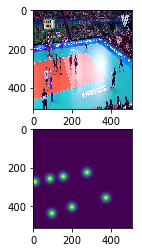

In [17]:
show_masks(train_imgs[0], train_masks[0])

In [40]:
from keras.callbacks import EarlyStopping, CSVLogger

def UNET(input_shape):
    def downsample_block(x, block_num, n_filters, pooling_on=True):

        x = Conv2D(n_filters, kernel_size=(3, 3), strides=1, padding='same', activation='relu',
                   name="Block" + str(block_num) + "_Conv1")(x)
        x = Conv2D(n_filters, kernel_size=(3, 3), strides=1, padding='same', activation='relu',
                   name="Block" + str(block_num) + "_Conv2")(x)
        skip = x

        if pooling_on is True:
            x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', name="Block" + str(block_num) + "_Pool1")(x)

        return x, skip

    def upsample_block(x, skip, block_num, n_filters):

        x = Conv2DTranspose(n_filters, kernel_size=(2, 2), strides=2, padding='valid', activation='relu',
                            name="Block" + str(block_num) + "_ConvT1")(x)
        x = concatenate([x, skip], axis=-1, name="Block" + str(block_num) + "_Concat1")
        x = Conv2D(n_filters, kernel_size=(3, 3), strides=1, padding='same', activation='relu',
                   name="Block" + str(block_num) + "_Conv1")(x)
        x = Conv2D(n_filters, kernel_size=(3, 3), strides=1, padding='same', activation='relu',
                   name="Block" + str(block_num) + "_Conv2")(x)

        return x

    input = Input(input_shape, name="Input")

    # downsampling
    x, skip1 = downsample_block(input, 1, 64)
    x, skip2 = downsample_block(x, 2, 128)
    x, skip3 = downsample_block(x, 3, 256)
    x, skip4 = downsample_block(x, 4, 512)
    x, _ = downsample_block(x, 5, 1024, pooling_on=False)

    # upsampling
    x = upsample_block(x, skip4, 6, 512)
    x = upsample_block(x, skip3, 7, 256)
    x = upsample_block(x, skip2, 8, 128)
    x = upsample_block(x, skip1, 9, 64)

    output = Conv2D(CLASSES, kernel_size=(1, 1), strides=1, padding='valid', activation='linear', name="output")(x)
    output = Reshape(target_shape=(IMAGE_SIZE[1] * IMAGE_SIZE[0] * CLASSES,1))(output)

    model = Model(inputs=input, outputs=output, name="Output")

    return model


unet = UNET(input_shape=(IMAGE_SIZE[1], IMAGE_SIZE[0], 1))

In [41]:
unet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
Block1_Conv1 (Conv2D)           (None, 512, 512, 64) 640         Input[0][0]                      
__________________________________________________________________________________________________
Block1_Conv2 (Conv2D)           (None, 512, 512, 64) 36928       Block1_Conv1[0][0]               
__________________________________________________________________________________________________
Block1_Pool1 (MaxPooling2D)     (None, 256, 256, 64) 0           Block1_Conv2[0][0]               
__________________________________________________________________________________________________
Block2_Con

In [42]:
import tensorflow as tf

def jaccard(ytrue, ypred, smooth=1e-5):

    intersection = tf.sum(tf.abs(ytrue * ypred), axis=-1)
    union = np.sum(tf.abs(ytrue) + tf.abs(ypred), axis=-1)
    jac = (intersection + smooth) / (union - intersection + smooth)

    return tf.mean(jac)

In [43]:
def mean_squared_error(y_true, y_pred):
    channel_loss = tf.sum(tf.square(y_pred - y_true), axis=-1)
    total_loss = tf.mean(channel_loss, axis=-1)
    return total_loss

In [44]:
def create_callbacks(patience=5):

    cbks = []

    # early stopping
    early_stopper = EarlyStopping(monitor='val_loss', patience=patience)
    cbks.append(early_stopper)

    model_chpt = ModelCheckpoint(filepath='weights.h5',
                                 monitor='val_loss',
                                 verbose=1,
                                 save_weights_only=True,
                                 save_best_only=True,
                                 period=patience)

    cbks.append(model_chpt)
    
    # csv logger
    csv_logger = CSVLogger('train_log.csv')
    cbks.append(csv_logger)

    return cbks

In [54]:
callbacks = create_callbacks()

optim = RMSprop(lr=1e-3)

model = unet
    
model.compile(loss="mean_squared_error", optimizer=optim, metrics=None)
model.fit_generator(generator=train_gen,
                    validation_data=valid_gen,
                    epochs=10,
                    callbacks=callbacks)

TypeError: __len__() takes 0 positional arguments but 1 was given